# BackTesting simple trading strategy

I am currently getting to know algorithmic trading, and I would really appreciate constructive feedback.

This notebook is an exploration of the use of trading indicators, followed by the formulation of a strategy based on what I believe will optimize my gains.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
!pip install yfinance
import yfinance as yf

  Preparing metadata (setup.py) ... - done
  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=3a27621df9fe2b2fc4cc890201353c5860a403b9caee1e1a5d24b08eddbb6c54
  Stored in directory: /root/.cache/pip/wheels/34/ba/79/c0260c6f1a03f420ec7673eff9981778f293b9107974679e36
Successfully built multitasking


In [2]:
stock = web.get_data_yahoo('AAPL', '2018-1-2', '2022-2-15')
stock.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,43.075001,42.314999,42.540001,43.064999,102223600.0,41.135754
2018-01-03,43.637501,42.990002,43.132500,43.057499,118071600.0,41.128593
2018-01-04,43.367500,43.020000,43.134998,43.257500,89738400.0,41.319626
2018-01-05,43.842499,43.262501,43.360001,43.750000,94640000.0,41.790073
2018-01-08,43.902500,43.482498,43.587502,43.587502,82271200.0,41.634850


## Obtaining Trading Indicators

### Simple Moving Average
* The average closing price for the last n days
* Filters out random short-term price fluctuations

### SMA Crossovers
* Utilizing two SMAs, one for the shorter term and the other for a longer term
* When the shorter SMA crosses above the longer SMA, it forms the "Golden Cross" which is usually an entry signal. Conversely, the opposite is usually an exit signal

### Bollinger Bands (Trend-following indicator)
* measures the market volatility by looking at the standard price deviation from the average value.

$$
    UpperBand = SMA(n) + (m)*std(n)
$$
$$
    LowerBand = SMA(n) - (m)*std(n)
$$
n = Smoothing Period (usually 20), m = Number of std (usually 2)

* It is believed that as the price moves towards the UpperBand, it is more overbought
and as the price moves towards the LowerBand, it is more oversold.

### Relative Strength Index (RSI)
* RSI is momentum indicator that evaluates overbought or oversold conditions by measuring the magnitude of recent price changes for various assets.
* Use RSI to confirm Bollinger Bands indications

$$
     RS =  \frac{AvgGain}{AvgLoss}
$$

$$   
     RSI = 100 - \frac{100}{1+RS}
$$



* https://www.investopedia.com/terms/s/sma.asp#:~:text=A%20simple%20moving%20average%20(SMA)%20is%20an%20arithmetic%20moving%20average,periods%20in%20the%20calculation%20average.&text=Short%2Dterm%20averages%20respond%20quickly,averages%20are%20slower%20to%20react.
* https://www.investopedia.com/terms/b/bollingerbands.asp
* https://www.investopedia.com/articles/active-trading/042114/overbought-or-oversold-use-relative-strength-index-find-out.asp

In [3]:
 def obtainIndicators(stock):
    # Calculating the Indicators

    # Simple Moving Averages
    # Calculate 20-day-SMA (will be using this for the Bollinger Band)
    stock['20-SMA'] = stock['Close'].rolling(window=20).mean()

    # Calculating 50-day-SMA
    stock['50-SMA'] = stock['Close'].rolling(window=50).mean()
    
    # Calculating 50-day-SMA
    stock['200-SMA'] = stock['Close'].rolling(window=200).mean()

    # Calculating the 20-day-std
    std = stock['Close'].rolling(window=20).std()
    stock['std'] = std

    # Bollinger Bands
    # Calculating the UpperBand
    stock['UpperBand'] = stock['20-SMA'] + (2*std)

    #Calculating the LowerBand
    stock['LowerBand'] = stock['20-SMA'] - (2*std)

    # RSI
    # calculating delta (difference of closing price from prev day closing price)
    delta = stock['Close'].diff()
    # Extracting positive delta
    up = delta.clip(lower=0)
    # Extracting negative delta
    down = abs(delta.clip(upper=0))
    # Calculating average gain, usually over 14days
    avgGain = up.rolling(window=14).mean()
    # Calculating average loss
    avgLoss = down.rolling(window=14).mean()
    # RSI
    rs = avgGain/avgLoss
    stock['RSI'] = 100-(100/(1+rs))
    
    return stock.dropna(inplace=True)
    

In [4]:
obtainIndicators(stock)
stock.head()

,High,Low,Open,Close,Volume,Adj Close,20-SMA,50-SMA,200-SMA,std,UpperBand,LowerBand,RSI
Date,,,,,,,,,,,,,
2018-10-16,55.747501,54.189999,54.732498,55.537498,116736000.0,53.658718,55.676375,54.92185,47.399888,1.165636,58.007646,53.345103,51.642297
2018-10-17,55.660000,54.834999,55.575001,55.297501,91541600.0,53.426842,55.711625,54.99225,47.461050,1.141544,57.994713,53.428537,46.171084
2018-10-18,54.935001,53.250000,54.465000,54.005001,130325200.0,52.178070,55.661500,55.03610,47.515788,1.194854,58.051209,53.271791,40.912486
2018-10-19,55.314999,54.357498,54.514999,54.827499,132314800.0,52.972736,55.682125,55.08825,47.573638,1.175611,58.033346,53.330904,42.805431
2018-10-22,55.840000,54.735001,54.947498,55.162498,115168400.0,53.296410,55.680375,55.15385,47.630700,1.176396,58.033167,53.327583,42.092717


## Lets look at the indicators by itself

# SMA Crossover

## Observations

What I've realised is that the trend after the golden cross tends to be increasing but it dips slightly whenever the 50-SMA deviates significantly away from the 200-SMA.

## Strategy
* Entry when sma50 is greather than sma200 but sell when sma50 is greater than 1.2x of sma200.
* Exit when sma50 is lesser than sma200 but buy when sma50 is less than 0.8x of sma200

In [5]:
def getSMACross(stock):
    entry = []
    exit = []

    for i in range(len(stock['Close'])):
        close = stock['Close'][i]
        sma50 = stock['50-SMA'][i]
        sma200 = stock['200-SMA'][i]

        if (sma50 < sma200 and sma50 > sma200*.8) or (sma50 > sma200*1.2):
            entry.append(np.nan)
            exit.append(close)
        elif (sma50 > sma200 and sma50 < sma200*1.2) or (sma50 < sma200*.8):
            entry.append(close)
            exit.append(np.nan)
        else:
            entry.append(np.nan)
            exit.append(np.nan)
    return entry, exit


entry, exit = getSMACross(stock)

[]

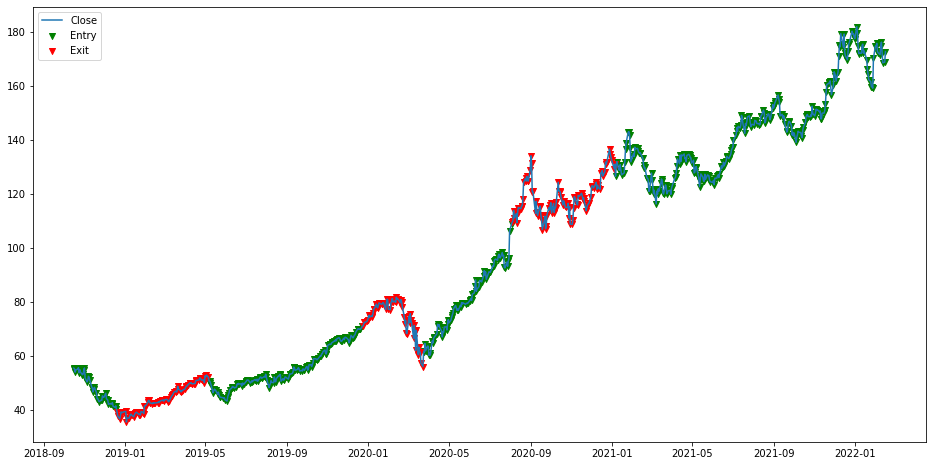

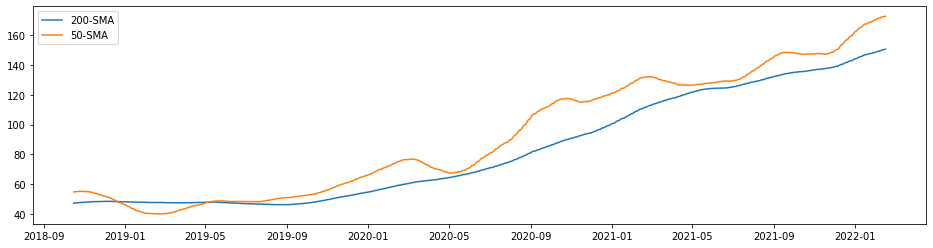

In [6]:
xaxis = stock.index
plt.figure(figsize=(16, 8))
plt.plot(xaxis, stock['Close'], label='Close')
plt.scatter(xaxis, entry, color='green', marker='v', label='Entry')
plt.scatter(xaxis, exit, color='red', marker='v', label='Exit')
plt.legend()
plt.plot()

plt.figure(figsize=(16, 4))
plt.plot(xaxis, stock['200-SMA'], label='200-SMA')
plt.plot(xaxis, stock['50-SMA'], label='50-SMA')
plt.legend()
plt.plot()

# Bollinger Bands

## Observations
In general, the trend increases whenever it crosses the 20-SMA, but rebounds whenever it touches the upper band. Declining trends exhibit the same behavior.

## Strategy
Start entry when close is above 20-SMA and exit when close goes above the upper band,
Start exit when close is below 20-SMA and exit when close goes below the lower band.

In [7]:
def getBBSignal(stock):
    entry = []
    exit = []

    for i in range(len(stock['Close'])):
        close = stock['Close'][i]
        upper = stock['UpperBand'][i]
        lower = stock['LowerBand'][i]
        sma20 = stock['20-SMA'][i]

        if close < sma20 or close >= upper:
            entry.append(np.nan)
            exit.append(close)
        elif close > sma20 or close <= lower:
            entry.append(close)
            exit.append(np.nan)
        else:
            entry.append(np.nan)
            exit.append(np.nan)
    return entry, exit


entry, exit = getBBSignal(stock)

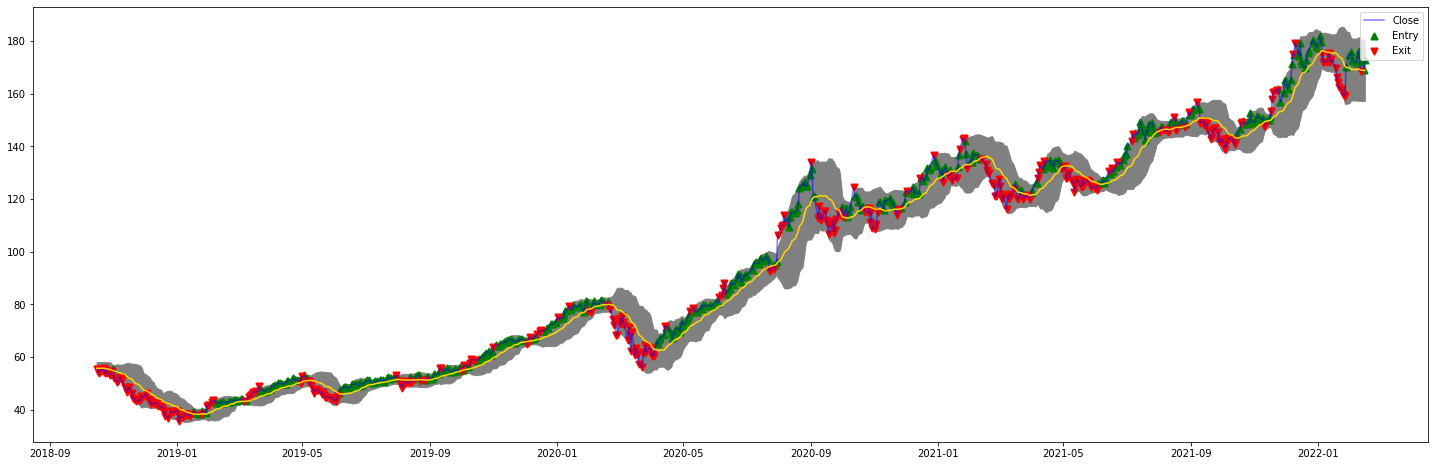

In [8]:

xaxis = stock.index
plt.figure(figsize=(25, 8))
plt.fill_between(xaxis, stock['UpperBand'], stock['LowerBand'], color='gray')
plt.plot(xaxis, stock['Close'], color='blue', alpha=0.5, label='Close')
plt.plot(xaxis, stock['20-SMA'], color='gold')
plt.scatter(xaxis, entry, color='green', marker='^', lw=2, label='Entry')
plt.scatter(xaxis, exit, color='red', marker='v', lw=2, label='Exit')
plt.legend()

# RSI

## Observations
* RSI provides crucial insights into the state of the asset, but cannot predict how long a trend will last by itself.
* It is commonly recommended to use Bollinger Bands along with RSI to provide better indications, which is exactly what I will attempt to do

## Strategy
* Entry when RSI < 30 (indicating a oversold asset) and close price falls below the lower band (indicating that the price might turn around since it has deviated by over 2 std), and vice versa.

## Remarks
* The first plot shows what will happen if we only take a look at the RSI, and the second plot illustrates the above strategy

In [9]:
def getRSISignal(stock):
    entry = []
    exit = []

    for i in range(len(stock['Close'])):
        close = stock['Close'][i]
        rsi = stock['RSI'][i]

        if rsi >= 70:
            exit.append(close)
            entry.append(np.nan)
        elif rsi <= 30:
            exit.append(np.nan)
            entry.append(close)
        else:
            entry.append(np.nan)
            exit.append(np.nan)
    return entry, exit


entry, exit = getRSISignal(stock)

[]

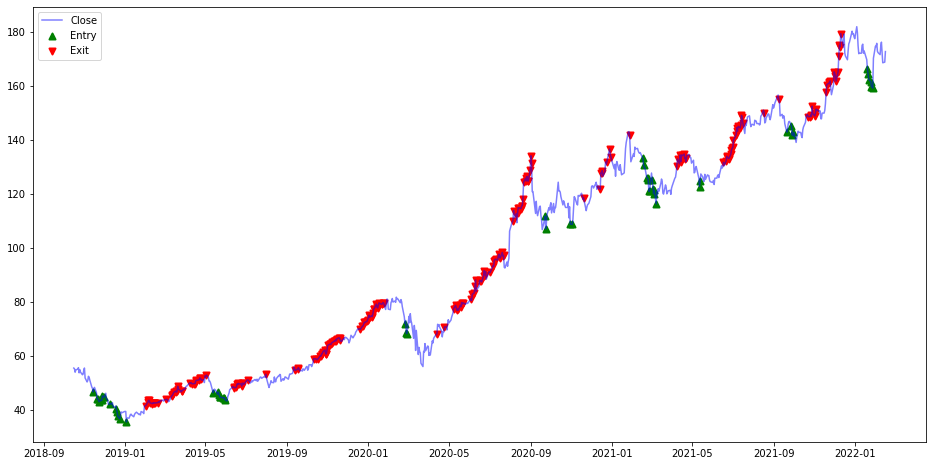

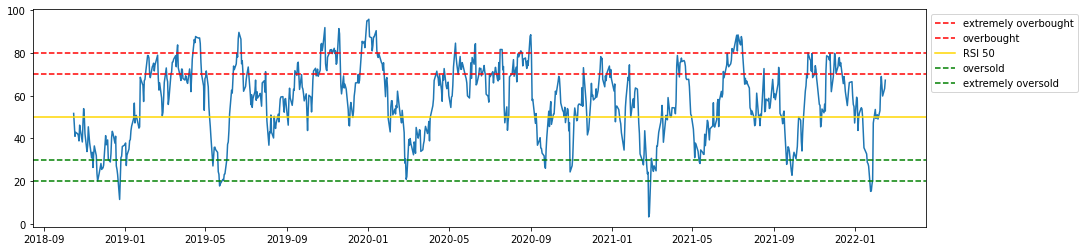

In [10]:
xaxis = stock.index
plt.figure(figsize=(16, 8))
plt.plot(xaxis, stock['Close'], color='blue', alpha=0.5, label='Close')
plt.scatter(xaxis, entry, color='green', marker='^', lw=2, label='Entry')
plt.scatter(xaxis, exit, color='red', marker='v', lw=2, label='Exit')
plt.legend()
plt.plot()

plt.figure(figsize=(16, 4))
plt.plot(stock['RSI'])
plt.axhline(80, linestyle='--', color='red', label='extremely overbought')
plt.axhline(70, linestyle='--', color='red', label='overbought')
plt.axhline(50, color='gold', label='RSI 50')
plt.axhline(30, linestyle='--', color='green',  label='oversold')
plt.axhline(20, linestyle='--', color='green', label='extremely oversold')
plt.legend(bbox_to_anchor=(1, 1))
plt.plot()

In [11]:
def getRSISignalWithBB(stock):
    entry = []
    exit = []

    for i in range(len(stock['Close'])):
        close = stock['Close'][i]
        rsi = stock['RSI'][i]
        sma20 = stock['20-SMA'][i]
        upper = stock['UpperBand'][i]
        lower = stock['LowerBand'][i]

        if rsi >= 70 and close >= upper:
            exit.append(close)
            entry.append(np.nan)
        elif rsi <= 30 and close <= lower:
            exit.append(np.nan)
            entry.append(close)
        else:
            entry.append(np.nan)
            exit.append(np.nan)
    return entry, exit


entry, exit = getRSISignalWithBB(stock)

[]

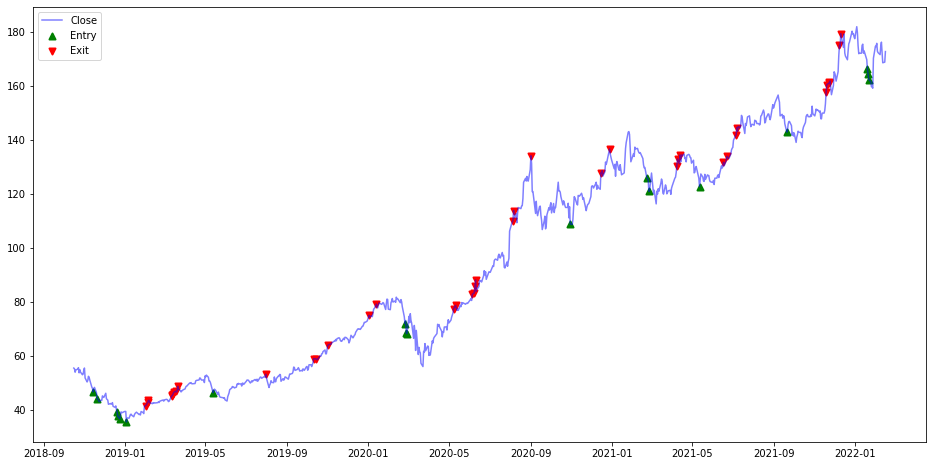

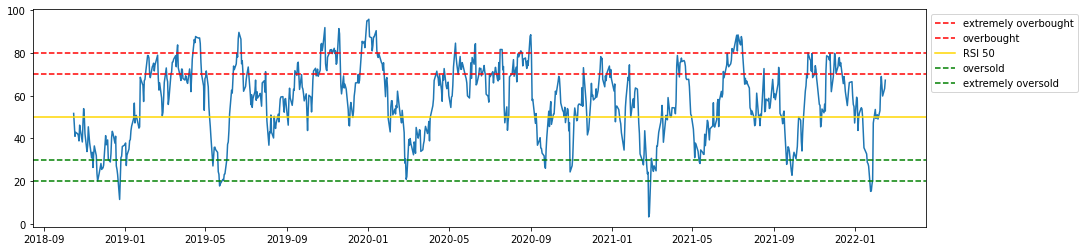

In [12]:

xaxis = stock.index
plt.figure(figsize=(16, 8))
plt.plot(xaxis, stock['Close'], color='blue', alpha=0.5, label='Close')
plt.scatter(xaxis, entry, color='green', marker='^', lw=2, label='Entry')
plt.scatter(xaxis, exit, color='red', marker='v', lw=2, label='Exit')
plt.legend()
plt.plot()

plt.figure(figsize=(16, 4))
plt.plot(stock['RSI'])
plt.axhline(80, linestyle='--', color='red', label='extremely overbought')
plt.axhline(70, linestyle='--', color='red', label='overbought')
plt.axhline(50, color='gold', label='RSI 50')
plt.axhline(30, linestyle='--', color='green',  label='oversold')
plt.axhline(20, linestyle='--', color='green', label='extremely oversold')
plt.legend(bbox_to_anchor=(1, 1))
plt.plot()

# Backtesting

* Currently, I'm exploring the Backtrader package, but it seems tricky to implement on Kaggle. As a consequence, I will be backtrading with a hastily constructed script.
* Because I am still relatively new to this, the backtesting script is purely based on my perception of how it might work.

In [13]:
class backtesting:

    def __init__(self, cash=100000, ticker='AAPL', start='2000-1-2', end='2022-2-1', interval='1d', fee=0):
        self.cash = cash

        self.fee = fee

        self.ticker = ticker

        self.portfolio = {}

        self.entries = []

        self.exits = []
        
        self.lastBoughtPrice = 0

        self.idx = start
        
        self.portfolio[self.ticker] = 0
        
        self.data = yf.download(ticker, start=start, end=end, interval=interval)
        
        self.currdate = self.data.index[0]

        self.portfolioValue = self.portfolio[self.ticker] * self.data.loc[self.currdate]['Close']

        

    def getCash(self):
        return self.cash

    def getTicker(self):
        return self.ticker

    def getPortfolio(self):
        return self.portfolio
    
    def getPortfolioValue(self):
        return self.portfolio[self.ticker] * self.data.loc[self.currdate]['Close']

    def getOverallValue(self):
        print(f"Value of portfolio: {self.portfolioValue}, Cash: {self.cash}, Overall Value: {self.cash+self.portfolioValue}")
        return self.cash + self.portfolioValue

    def getData(self):
        return self.data

    def setFee(self, fee):
        self.fee = fee

    def setCash(self, cash):
        self.cash = cash

    def setTicker(self, ticker):
        self.ticker = ticker

    def updateData(self, f):
        f(self.data)


    # Entry
    def entry(self, idx, close, amt=10):
        if self.cash < amt*close + self.fee:
            amt = self.cash // (close)
        
        if amt > 0:
            self.portfolio[self.ticker] += amt
            self.cash -= amt*close - self.fee
            self.entries.append(close)
            self.exits.append(np.nan)
            print(f'entry: {close}')
            self.lastBoughtPrice = close
        else:
            self.entries.append(np.nan)
            self.exits.append(np.nan)

            

    # Exit
    def exit(self, idx, close, amt=5):
        if self.portfolio[self.ticker] >= amt:
            self.cash += amt * close - self.fee
            self.portfolio[self.ticker] -= amt
            self.entries.append(np.nan)
            self.exits.append(close)
            print(f'exit: {close}')

        else:
            if self.portfolio[self.ticker] > 0:
                self.cash += self.portfolio[self.ticker] * close - self.fee
                self.portfolio[self.ticker] = 0
                self.entries.append(np.nan)
                self.exits.append(close)
                print(f'exit: {close}')
            
            else:
                self.entries.append(np.nan)
                self.exits.append(np.nan)

    def hold(self):
        self.entries.append(np.nan)
        self.exits.append(np.nan)
            
            
    def strategy(self):
        idx = self.currdate
        close = self.data.loc[idx]['Close']
        rsi = self.data.loc[idx]['RSI']
        upper = self.data.loc[idx]['UpperBand']
        lower = self.data.loc[idx]['LowerBand']
        sma20 = self.data.loc[idx]['20-SMA']
        sma50 = self.data.loc[idx]['50-SMA']

        if rsi <= 30 and close <= lower or rsi <20:
            self.entry(idx, close, 10)
        elif rsi >= 70 and close >= upper or rsi > 90:
            self.exit(idx, close, 10)
        else:
            self.entries.append(np.nan)
            self.exits.append(np.nan)
            
    def run(self):
        for idx in self.data.index:
            self.currdate = idx
            self.strategy()
            self.portfolioValue = self.portfolio[self.ticker] * self.data.loc[self.currdate]['Close']

    def plotBT(self):
        plt.figure(figsize=(16, 8))
        # print(len(self.data.index), len(self.entries), len(self.exits))
        xaxis = self.data.index[:]
        plt.plot(xaxis, self.data['Close'])
        plt.plot(xaxis, self.data['UpperBand'])
        plt.plot(xaxis, self.data['LowerBand'])
        
        
        if self.entries.count(np.nan) != len(self.entries):
            plt.scatter(xaxis, self.entries, color='green', lw=3, marker='^')
        
        if self.exits.count(np.nan) != len(self.exits):
            plt.scatter(xaxis, self.exits, color='red', lw=3, marker='v')
            
        plt.figure(figsize=(16, 4))
        plt.plot(xaxis, self.data['RSI'])
        plt.axhline()
        plt.axhline(80, linestyle='--', color='red', label='extremely overbought')
        plt.axhline(70, linestyle='--', color='red', label='overbought')
        plt.axhline(50, color='gold', label='RSI 50')
        plt.axhline(30, linestyle='--', color='green',  label='oversold')
        plt.axhline(20, linestyle='--', color='green', label='extremely oversold')


In [14]:
bt = backtesting(ticker="AAPL", start='2018-1-2', end='2022-2-1')
bt.setCash(1000)
bt.setFee = 2.99
bt.updateData(obtainIndicators)
bt.run()
print(bt.getOverallValue())
print(bt.getPortfolio())

[*********************100%***********************]  1 of 1 completed
entry: 46.70000076293945
entry: 44.244998931884766
entry: 44.19499969482422
exit: 41.630001068115234
exit: 42.8125
exit: 43.54499816894531
entry: 46.43000030517578
entry: 44.915000915527344
exit: 53.2599983215332
exit: 59.0525016784668
entry: 72.0199966430664
entry: 68.37999725341797
exit: 77.53250122070312
exit: 78.75250244140625
entry: 108.86000061035156
exit: 127.87999725341797
entry: 126.0
entry: 120.98999786376953
exit: 130.36000061035156
exit: 133.0
entry: 122.7699966430664
exit: 131.7899932861328
entry: 142.94000244140625
exit: 157.8699951171875
entry: 166.22999572753906
Value of portfolio: 1747.7999877929688, Cash: 83.71998596191406, Overall Value: 1831.5199737548828
1831.5199737548828
{'AAPL': 10}


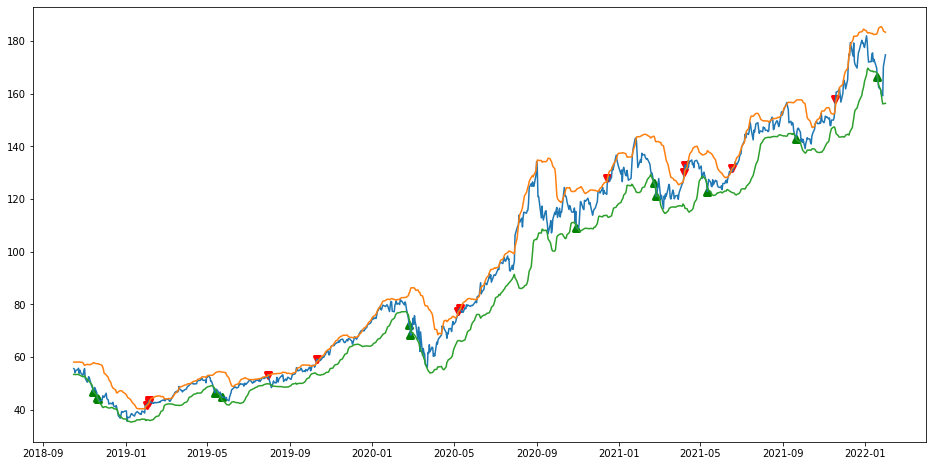

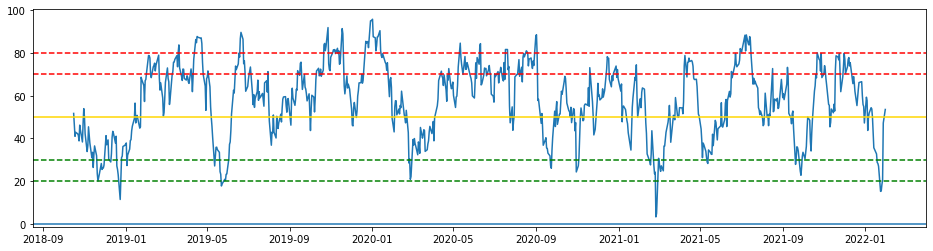

In [15]:
bt.plotBT()

## Lets test this on the Crypto Market as well

In [16]:
bt = backtesting(ticker="DOGE-USD", start='2022-2-22', end='2022-2-23', interval='1m')
bt.setCash(10)
bt.updateData(obtainIndicators)
bt.run()
print(bt.getOverallValue())
print(bt.getPortfolio())

[*********************100%***********************]  1 of 1 completed
entry: 0.1255597025156021
entry: 0.12558260560035706
entry: 0.12570436298847198
entry: 0.12580253183841705
entry: 0.1257387101650238
entry: 0.1257203370332718
entry: 0.12568770349025726
entry: 0.1256009191274643
exit: 0.1263609677553177
exit: 0.1263439953327179
exit: 0.1271795928478241
entry: 0.1262565404176712
exit: 0.12707321345806122
exit: 0.1270887553691864
exit: 0.12734828889369965
entry: 0.12660978734493256
entry: 0.12653182446956635
entry: 0.12660351395606995
entry: 0.12658260762691498
entry: 0.12660250067710876
exit: 0.12742500007152557
exit: 0.1274208128452301
exit: 0.12750312685966492
exit: 0.12752185761928558
exit: 0.1277713030576706
exit: 0.12783268094062805
exit: 0.12783145904541016
exit: 0.12784673273563385
entry: 0.1279178261756897
entry: 0.1281103938817978
entry: 0.12811119854450226
entry: 0.12809306383132935
entry: 0.1280735284090042
entry: 0.12789155542850494
entry: 0.1279136687517166
entry: 0.127916

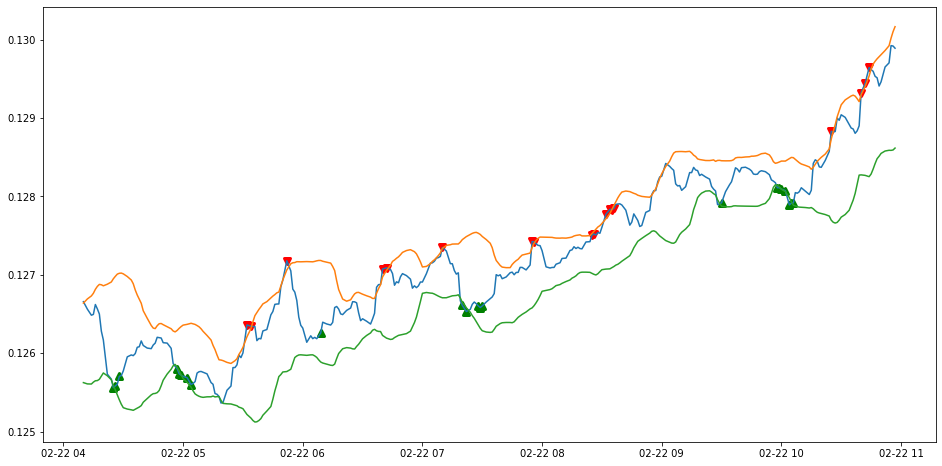

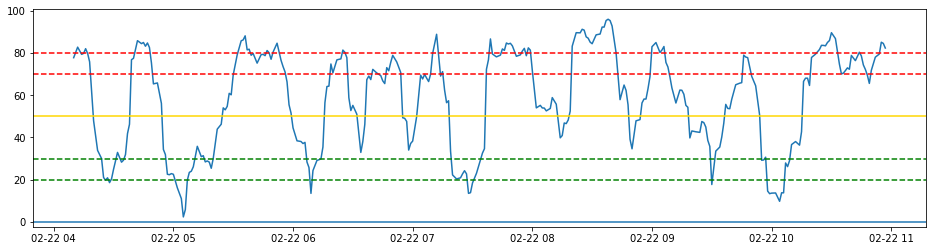

In [17]:
bt.plotBT()

In [18]:
bt = backtesting(ticker="CRO-USD", start='2022-2-22', end='2022-2-23', interval='1m')
bt.setCash(10)
bt.updateData(obtainIndicators)
bt.run()
print(bt.getOverallValue())
print(bt.getPortfolio())

[*********************100%***********************]  1 of 1 completed
entry: 0.374403715133667
entry: 0.3742298483848572
entry: 0.3741016685962677
exit: 0.3746396601200104
exit: 0.3746591806411743
exit: 0.37493088841438293
entry: 0.37320154905319214
entry: 0.37316498160362244
entry: 0.3731916844844818
exit: 0.37368258833885193
exit: 0.3744114339351654
exit: 0.3745117783546448
entry: 0.37594112753868103
entry: 0.3753991425037384
entry: 0.3754684031009674
exit: 0.3779383599758148
exit: 0.3788415789604187
exit: 0.3788631856441498
Value of portfolio: 0.0, Cash: 10.111588954925537, Overall Value: 10.111588954925537
10.111588954925537
{'CRO-USD': 0}


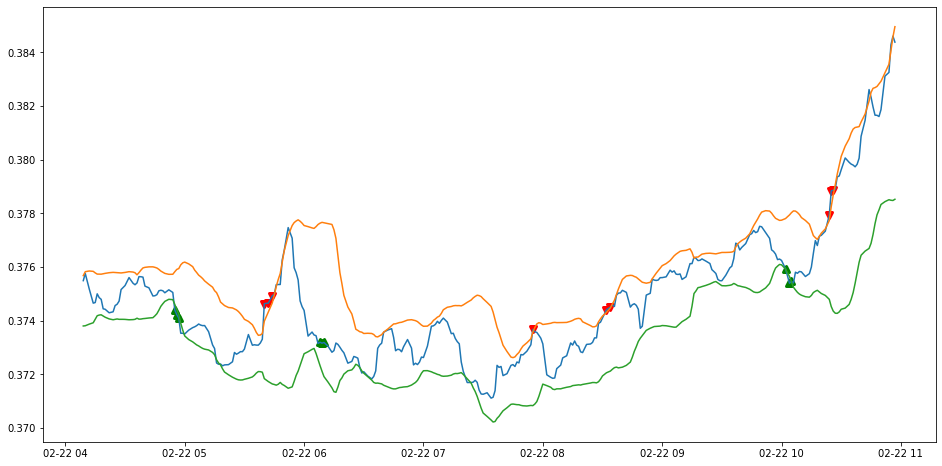

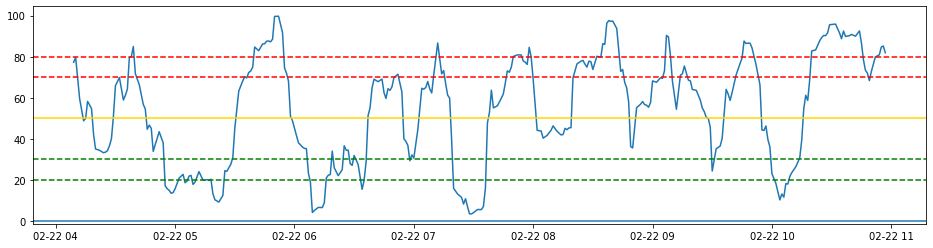

In [19]:
bt.plotBT()

In [20]:
bt = backtesting(ticker="XRP-USD", start='2022-2-22', end='2022-2-23', interval='1m')
bt.setCash(10)
bt.updateData(obtainIndicators)
bt.run()
print(bt.getOverallValue())
print(bt.getPortfolio())

[*********************100%***********************]  1 of 1 completed
entry: 0.6801062226295471
entry: 0.6802182197570801
exit: 0.6849989891052246
exit: 0.685348629951477
entry: 0.6882615089416504
entry: 0.6870458722114563
exit: 0.69361811876297
exit: 0.6933034062385559
entry: 0.6863757967948914
entry: 0.6856544613838196
exit: 0.6865180730819702
exit: 0.6865238547325134
entry: 0.6919475793838501
entry: 0.6915341019630432
exit: 0.6969626545906067
exit: 0.6970599889755249
Value of portfolio: 0.0, Cash: 10.225200176239014, Overall Value: 10.225200176239014
10.225200176239014
{'XRP-USD': 0}


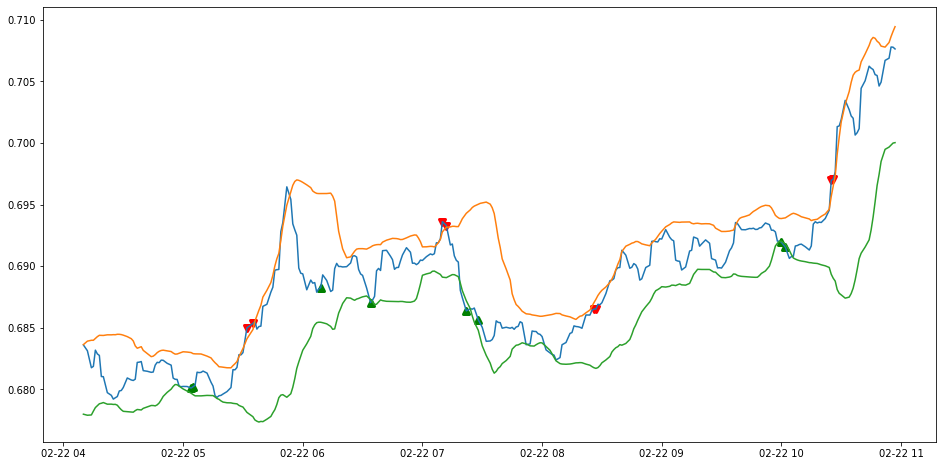

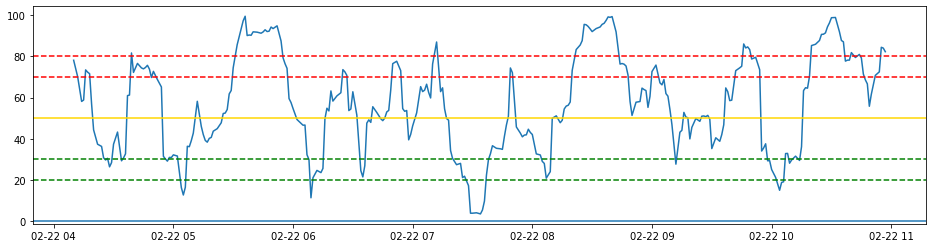

In [21]:
bt.plotBT()

## Ending remarks

* The backtrading simulation is only based on the closing price and does not fully reflect other market factors E.g. when and if the order will be filled

* Having a background in Data Science and Machine Learning, the finance field has always appealed to me and I would love to get deeper into it.

* Any suggestions on what platforms and tools I should consider, or maybe even some analytical perspectives I should be looking at in order to improve would be greatly appreciated.

